**summary**


1. I did explorative data analysis and visualization to understand the dataset. The target variable is highly imbalanced. Some features are very skewed.
2. I dropped out highly correlated features, non predictive features, and features with high percentage of missing value.
3. I processed features by filling missing numerical feature using median, and encoded categorical features using LabelEncoder.
4. I trained a standard random forest model and tunning hyperparameters using K fold cross validation. I used the trained model to predict the probability of booking for each search-property pair in the test set. For each search, the property was ranked by the probability of booking in descending order. Then I trained a random forest model with balanced class weight and a BalancedBaggingClassifier with undersampling strategy. But they didn't improve the performance significantly.
5. I checked feature importance of random forest model. prop_review_count is the most important feature. It is reasonalbe that people like to book property with high number of reviews. 

**Future work**


1. Impute missing value using regression model or classification based on features with no missing value.
2. Use other categorical encoding approach like OneHot encoding for low cardinality categorical features, and embedding for high cardinality categorical features.
3. Use SMOTE oversampling to deal with imbalanced dataset.
4. Train other models like XGboost, mutiperceptron neural network to predict the probability of booking.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import ndcg_score, average_precision_score
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Part1. Data Exploration

In [180]:
df = pd.read_csv('drive/My Drive/train.csv')
test = pd.read_csv('drive/My Drive/test.csv')

In [ ]:
df.head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,257690,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5605.0,186.72,3356.0,111.80,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,575,4.1,403.0,0,2014-09-13
1,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,4614.0,153.71,2769.0,92.24,1,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
2,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14026.0,467.25,2821.0,93.98,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13
3,-1046322713,3308025,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14308.0,476.65,5202.0,173.30,0,0,1,5.0,APAC,ASIA,JAPAN,60041,98278,272,4.8,221.0,0,2014-09-13
4,-1046322713,3222046,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5445.0,181.39,2589.0,86.25,0,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,198,3.9,702.0,0,2014-09-13


In [ ]:
df.shape

(841115, 47)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841115 entries, 0 to 841114
Data columns (total 50 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   srch_id                            841115 non-null  int64  
 1   prop_key                           841115 non-null  int64  
 2   srch_date_time                     841115 non-null  object 
 3   srch_visitor_id                    841115 non-null  object 
 4   srch_visitor_visit_nbr             841115 non-null  float64
 5   srch_visitor_loc_country           841115 non-null  object 
 6   srch_visitor_loc_region            840992 non-null  object 
 7   srch_visitor_loc_city              841115 non-null  object 
 8   srch_visitor_wr_member             396237 non-null  object 
 9   srch_posa_continent                355867 non-null  object 
 10  srch_posa_country                  841115 non-null  object 
 11  srch_hcom_destination_id           8411

In [ ]:
# check duplicates
df[df.duplicated(keep=False)]

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date


In [ ]:
# Get target variable, check proporation of y = 1
y = df['prop_booking_bool']
print(y.sum()/df.shape[0] * 100)

2.854900935068332


In [ ]:
# Check missing value
df.isnull().sum()

srch_id                                   0
prop_key                                  0
srch_date_time                            0
srch_visitor_id                           0
srch_visitor_visit_nbr                    0
srch_visitor_loc_country                  0
srch_visitor_loc_region                 123
srch_visitor_loc_city                     0
srch_visitor_wr_member               444878
srch_posa_continent                  485248
srch_posa_country                         0
srch_hcom_destination_id                  0
srch_dest_longitude                       0
srch_dest_latitude                        0
srch_ci                                   0
srch_co                                   0
srch_ci_day                               0
srch_co_day                               0
srch_los                                  0
srch_bw                                   0
srch_adults_cnt                          18
srch_children_cnt                        18
srch_rm_cnt                     

In [ ]:
# Check unique vales for each column
df.nunique()

srch_id                              24013
prop_key                              6330
srch_date_time                       23873
srch_visitor_id                      23101
srch_visitor_visit_nbr                 267
srch_visitor_loc_country               151
srch_visitor_loc_region                599
srch_visitor_loc_city                 5092
srch_visitor_wr_member                   9
srch_posa_continent                      4
srch_posa_country                       67
srch_hcom_destination_id                10
srch_dest_longitude                     10
srch_dest_latitude                      10
srch_ci                                385
srch_co                                376
srch_ci_day                              7
srch_co_day                              7
srch_los                                27
srch_bw                                370
srch_adults_cnt                         16
srch_children_cnt                        9
srch_rm_cnt                              8
srch_mobile

In [ ]:
# Change 'srch_ci', 'srch_co', 'srch_local_date' from dat to date of year
df['srch_ci_days_of_year'] = pd.DatetimeIndex(df['srch_ci']).dayofyear
df['srch_co_days_of_year'] = pd.DatetimeIndex(df['srch_co']).dayofyear
df['srch_local_date_days_of_year'] = pd.DatetimeIndex(df['srch_local_date']).dayofyear


test['srch_ci_days_of_year'] = pd.DatetimeIndex(test['srch_ci']).dayofyear
test['srch_co_days_of_year'] = pd.DatetimeIndex(test['srch_co']).dayofyear
test['srch_local_date_days_of_year'] = pd.DatetimeIndex(test['srch_local_date']).dayofyear

In [ ]:
# Select numerical features
num = ['srch_visitor_visit_nbr', 'srch_los', 'srch_bw', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'prop_price_without_discount_usd', 'prop_price_with_discount_usd',
       'prop_room_capacity', 'prop_review_score', 'prop_review_count', 'srch_ci_days_of_year',
       'srch_co_days_of_year', 'srch_local_date_days_of_year']

In [ ]:
df[num] = df[num].astype(float)
test[num] = test[num].astype(float)

In [ ]:
df[num].describe()

,srch_visitor_visit_nbr,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,prop_price_without_discount_usd,prop_price_with_discount_usd,prop_room_capacity,prop_review_score,prop_review_count,srch_ci_days_of_year,srch_co_days_of_year,srch_local_date_days_of_year
count,841115.000000,841115.000000,841115.000000,841097.000000,841097.000000,841115.000000,8.410640e+05,8.410640e+05,841115.000000,841107.000000,841107.000000,841115.000000,841115.000000,841115.000000
mean,12.325977,2.677238,35.349157,2.019900,0.161467,1.113059,4.527640e+02,3.044565e+02,631.116457,4.024048,2160.753578,268.478656,266.750890,255.789186
std,31.788936,2.192103,49.506785,1.020626,0.546063,0.447657,6.864688e+03,4.205190e+03,1573.071335,0.547170,3075.169206,59.631902,65.552087,7.951623
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,-9998.000000,0.000000,0.000000,1.000000,1.000000,243.000000
25%,1.000000,1.000000,4.000000,2.000000,0.000000,1.000000,1.440000e+02,9.902000e+01,144.000000,3.800000,306.000000,258.000000,259.000000,249.000000
50%,3.000000,2.000000,17.000000,2.000000,0.000000,1.000000,2.730000e+02,1.890000e+02,306.000000,4.100000,937.000000,271.000000,272.000000,255.000000
75%,10.000000,3.000000,46.000000,2.000000,0.000000,1.000000,4.490000e+02,2.990000e+02,770.000000,4.400000,2550.000000,293.000000,294.000000,262.000000
max,1082.000000,28.000000,473.000000,16.000000,8.000000,8.000000,1.976733e+06,1.087117e+06,19235.000000,5.000000,32399.000000,365.000000,365.000000,270.000000


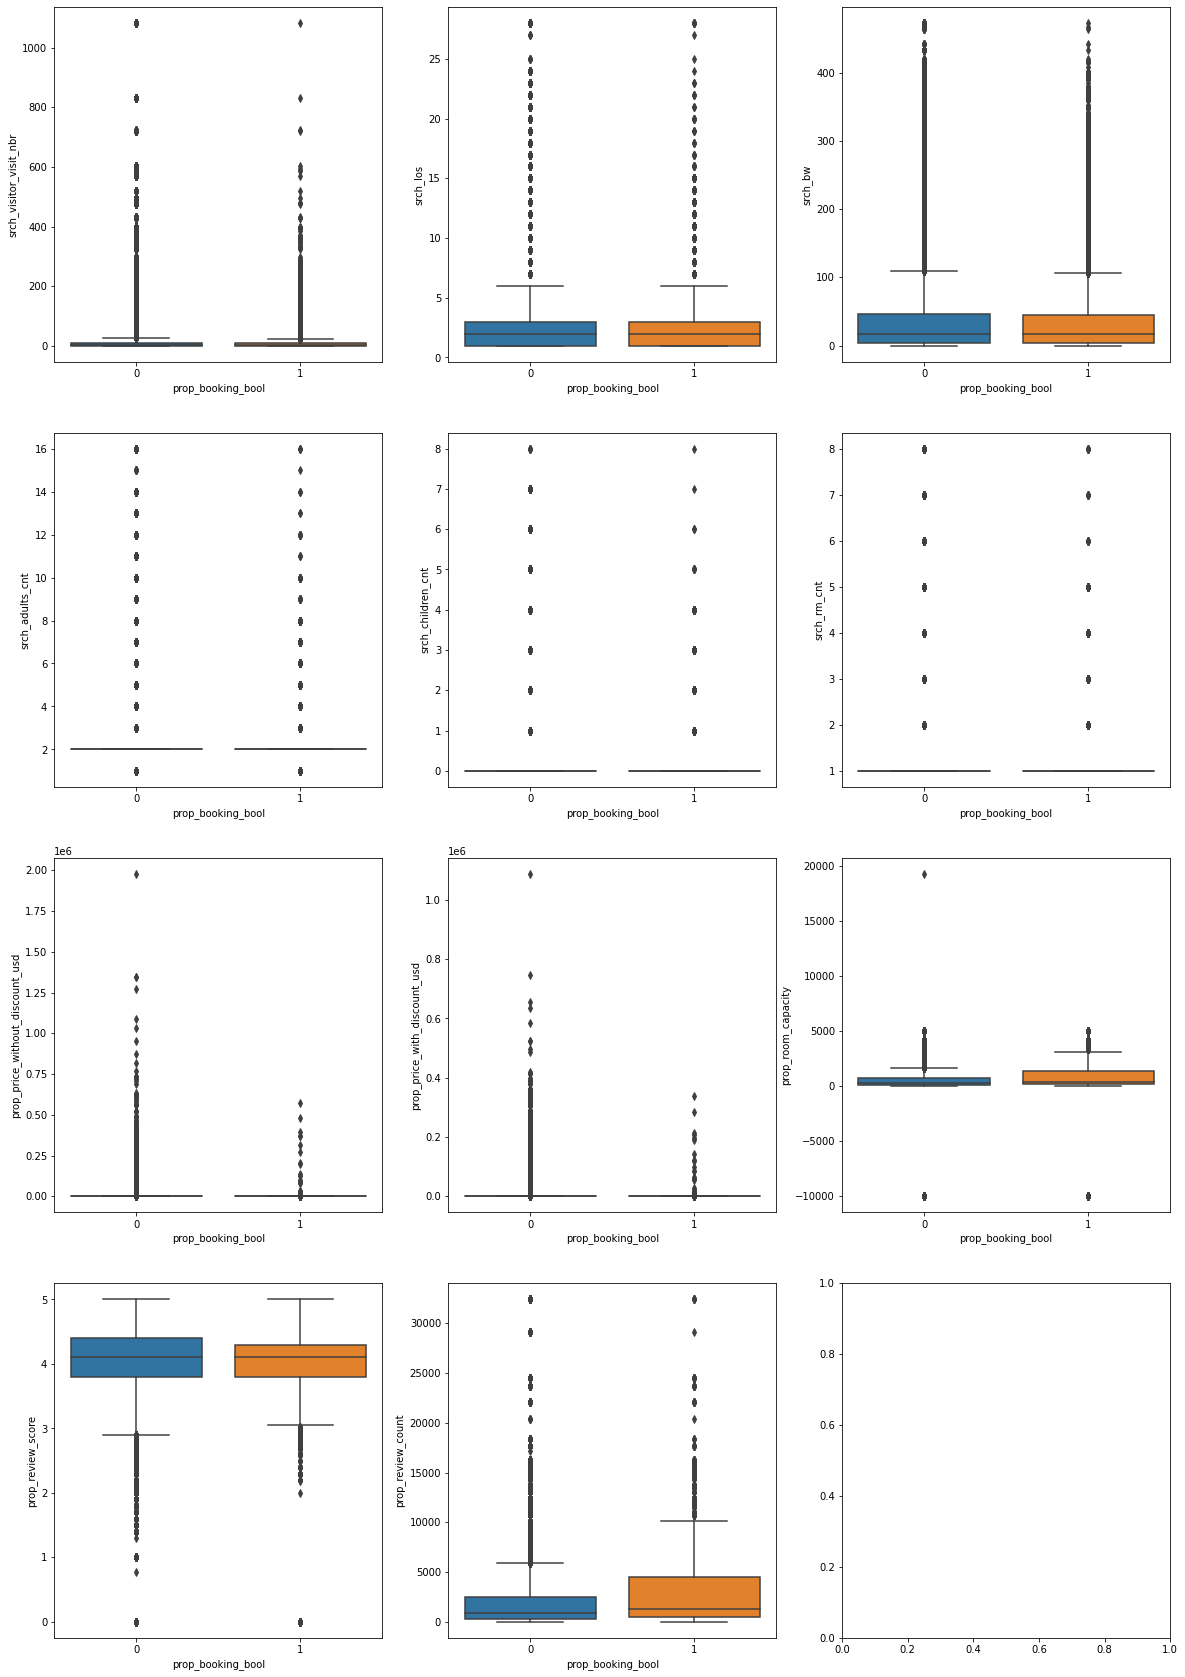

In [184]:
_, axss = plt.subplots(4, 3, figsize=[20, 30])
sns.boxplot(x='prop_booking_bool', y ='srch_visitor_visit_nbr', data=df, ax=axss[0][0])
sns.boxplot(x='prop_booking_bool', y ='srch_los', data=df, ax=axss[0][1])
sns.boxplot(x='prop_booking_bool', y ='srch_bw', data=df, ax=axss[0][2])
sns.boxplot(x='prop_booking_bool', y ='srch_adults_cnt', data=df, ax=axss[1][0])
sns.boxplot(x='prop_booking_bool', y ='srch_children_cnt', data=df, ax=axss[1][1])
sns.boxplot(x='prop_booking_bool', y ='srch_rm_cnt', data=df, ax=axss[1][2])
sns.boxplot(x='prop_booking_bool', y ='prop_price_without_discount_usd', data=df, ax=axss[2][0])
sns.boxplot(x='prop_booking_bool', y ='prop_price_with_discount_usd', data=df, ax=axss[2][1])
sns.boxplot(x='prop_booking_bool', y ='prop_room_capacity', data=df, ax=axss[2][2])
sns.boxplot(x='prop_booking_bool', y ='prop_review_score', data=df, ax=axss[3][0])
sns.boxplot(x='prop_booking_bool', y ='prop_review_count', data=df, ax=axss[3][1])
# several numerical features are very skewed, people like to book property with high number of reviews

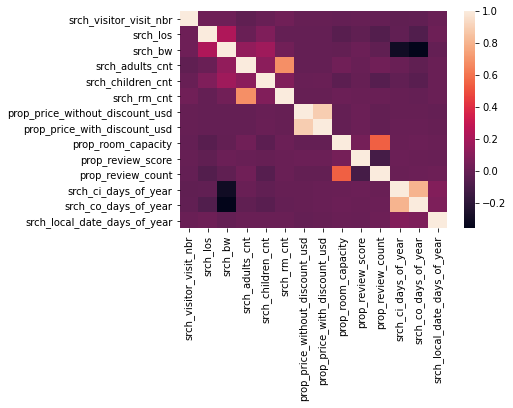

In [ ]:
sns.heatmap(df[num].corr())

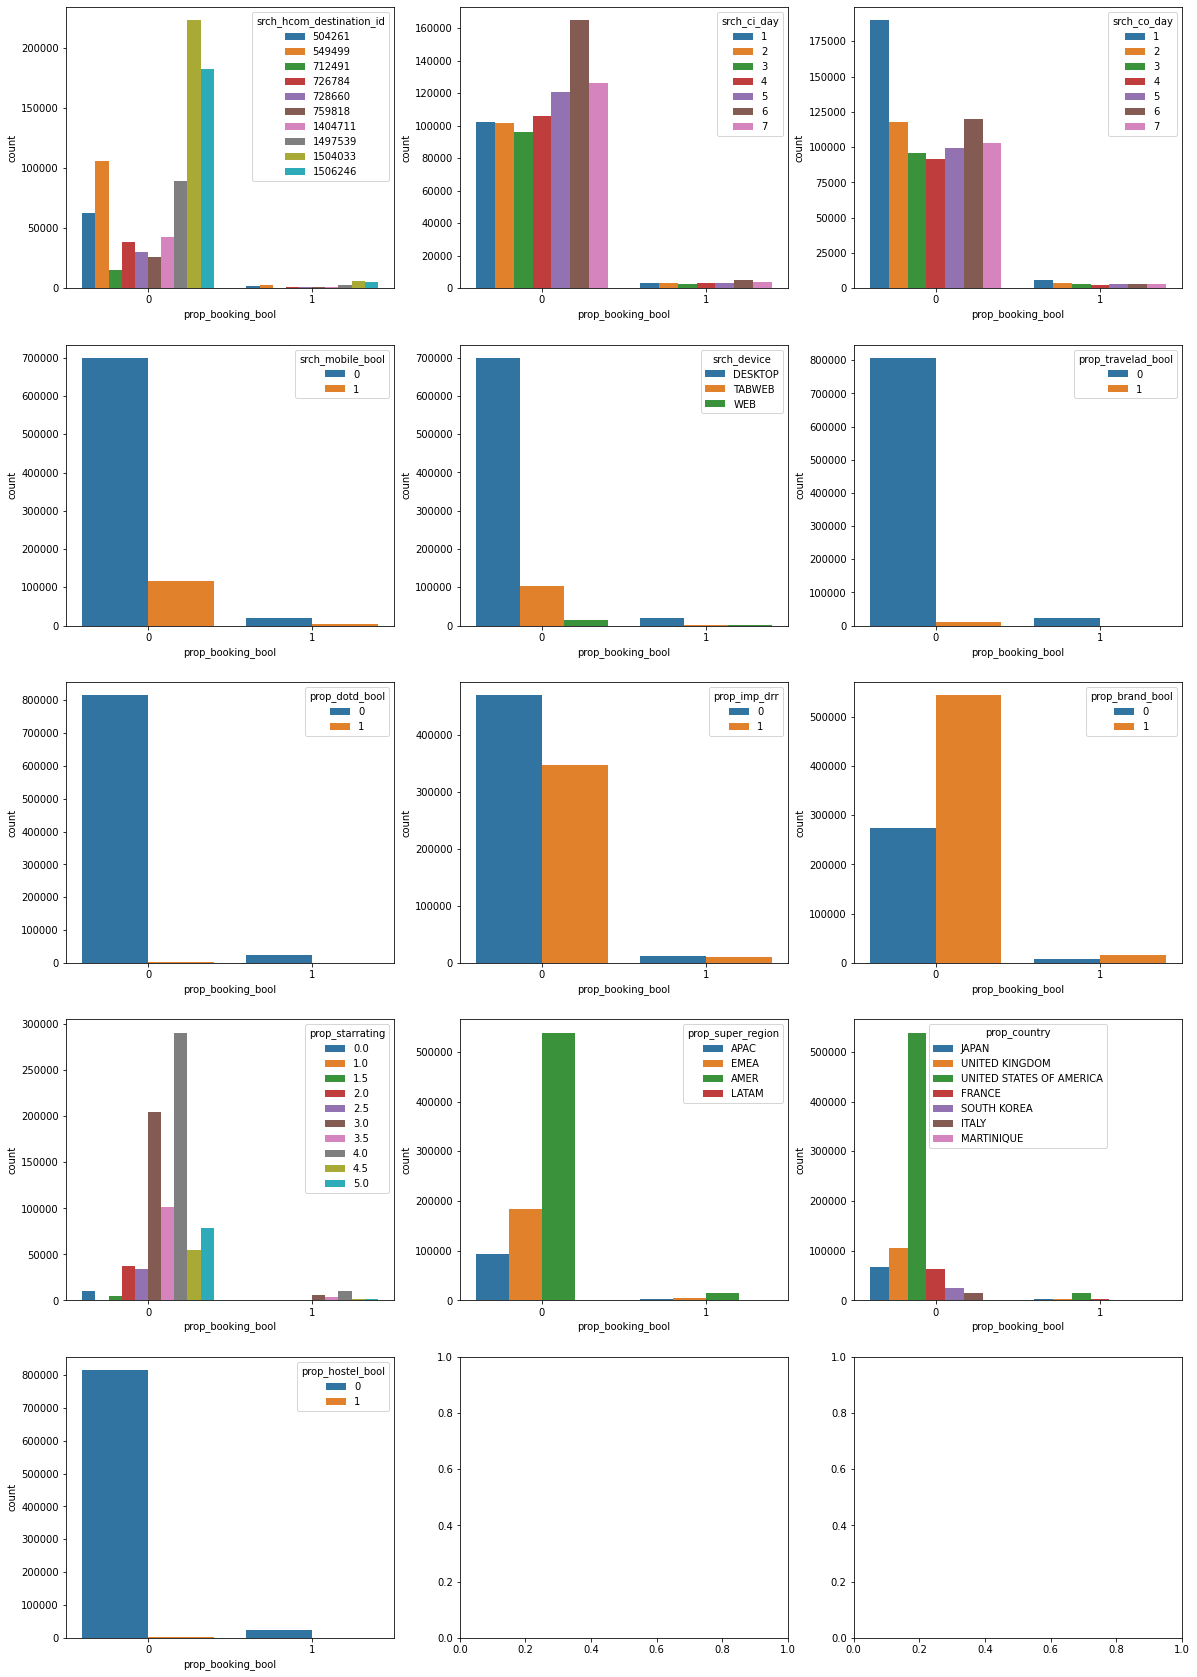

In [192]:
_,axss = plt.subplots(5,3, figsize=[20,30])
sns.countplot(x='prop_booking_bool', hue ='srch_hcom_destination_id', data=df, ax=axss[0][0])
sns.countplot(x='prop_booking_bool', hue ='srch_ci_day', data=df, ax=axss[0][1])
sns.countplot(x='prop_booking_bool', hue ='srch_co_day', data=df, ax=axss[0][2])
sns.countplot(x='prop_booking_bool', hue ='srch_mobile_bool', data=df, ax=axss[1][0])
sns.countplot(x='prop_booking_bool', hue ='srch_device', data=df, ax=axss[1][1])
sns.countplot(x='prop_booking_bool', hue ='prop_travelad_bool', data=df, ax=axss[1][2])
sns.countplot(x='prop_booking_bool', hue ='prop_dotd_bool', data=df, ax=axss[2][0])
sns.countplot(x='prop_booking_bool', hue ='prop_imp_drr', data=df, ax=axss[2][1])
sns.countplot(x='prop_booking_bool', hue ='prop_brand_bool', data=df, ax=axss[2][2])
sns.countplot(x='prop_booking_bool', hue ='prop_starrating', data=df, ax=axss[3][0])
sns.countplot(x='prop_booking_bool', hue ='prop_super_region', data=df, ax=axss[3][1])
sns.countplot(x='prop_booking_bool', hue ='prop_country', data=df, ax=axss[3][2])
sns.countplot(x='prop_booking_bool', hue ='prop_hostel_bool', data=df, ax=axss[4][0])

In [ ]:
# drop highly correlated featre, non predictive feature, feature with high percentage of missing value
to_drop1 = ['srch_id', 'prop_key', 'srch_date_time', 'srch_visitor_id', 'srch_visitor_wr_member',
           'srch_posa_continent', 'srch_dest_longitude', 'srch_dest_latitude', 'srch_ci', 'srch_co',
           'srch_mobile_app', 'srch_currency', 'prop_price_without_discount_local',
           'prop_price_with_discount_local', 'prop_continent', 'srch_local_date']

to_drop2 = ['srch_rm_cnt', 'prop_price_with_discount_usd', 'srch_co_days_of_year']
to_drop = to_drop1 + to_drop2

In [ ]:
X = df.drop(to_drop, axis=1)
X = X.drop(['prop_booking_bool'], axis=1)

In [ ]:
X_test = test.drop(to_drop, axis=1)

# Part2. Feature Preprocessing

In [ ]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y, random_state=42)

In [ ]:
num = [x for x in num if x not in to_drop2]
# fill missing for numerical
for col in num:
  if X_train[col].isnull().sum() > 0:
    X_train[col] = X_train[col].fillna(X_train[col].median())

  if X_val[col].isnull().sum() > 0:
    X_val[col] = X_val[col].fillna(X_val[col].median())

  if X_test[col].isnull().sum() > 0:
    X_test[col] = X_test[col].fillna(X_test[col].median())

In [ ]:
cat_low = ['srch_hcom_destination_id', 'srch_ci_day', 'srch_co_day', 'srch_mobile_bool', 'srch_device',
       'prop_travelad_bool', 'prop_dotd_bool', 'prop_imp_drr', 'prop_brand_bool',
       'prop_starrating', 'prop_super_region', 'prop_country', 'prop_hostel_bool']

cat_high = ['srch_visitor_loc_country', 'srch_visitor_loc_region', 'srch_visitor_loc_city', 'srch_posa_country',
             'prop_market_id', 'prop_submarket_id']

cat = cat_low + cat_high

In [ ]:
# Label encode categorical feature
for col in cat:
  X_train.loc[:, col] = X_train[col].astype(str)
  X_val.loc[:, col] = X_val[col].astype(str)
  X_test.loc[:, col] = X_test[col].astype(str)

  lbl = preprocessing.LabelEncoder()
  lbl.fit(X_train[col])
  X_val.loc[:, col] = X_val[col].map(lambda x : 'other' if x not in lbl.classes_ else x)
  X_test.loc[:, col] = X_test[col].map(lambda x : 'other' if x not in lbl.classes_ else x)

  lbl.classes_ = np.append(lbl.classes_, 'other')
  X_train.loc[:, col] = lbl.transform(X_train[col])
  X_val.loc[:, col] = lbl.transform(X_val[col])
  X_test.loc[:, col] = lbl.transform(X_test[col])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#Part3. Model training and evaluation

##3.1 Standard random forest model and hyperparameter tunning

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

CPU times: user 3min 32s, sys: 227 ms, total: 3min 33s
Wall time: 3min 34s


In [ ]:
def evaluation(estimator, X_val, y_val):
  y_pred = estimator.predict(X_val)
  probs = estimator.predict_proba(X_val)
  cm = metrics.confusion_matrix(y_val, y_pred)
  cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
  print(cmDF)
  print('precision_score is: ', precision_score(y_val, y_pred))
  print('recall_score is: ', recall_score(y_val, y_pred))
  print('roc_auc_score is: ', roc_auc_score(y_val, probs[:, 1]))
  print('f1_score is: ', f1_score(y_val, y_pred))

In [ ]:
evaluation(rf, X_val, y_val)

        pred_0  pred_1
true_0  245066      65
true_1    7164      40
precision_score is:  0.38095238095238093
recall_score is:  0.00555247084952804
roc_auc_score is:  0.6604483215493627
f1_score is:  0.01094540976877822


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20]}
clf = GridSearchCV(estimator = rf, param_grid=param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                  

In [ ]:
clf.best_params_

{'max_depth': 20, 'n_estimators': 200}

In [ ]:
rf_clf = clf.best_estimator_

In [ ]:
evaluation(rf_clf, X_val, y_val)

        pred_0  pred_1
true_0  240325    4806
true_1    6519     685
precision_score is:  0.12474959023857221
recall_score is:  0.09508606329816768
roc_auc_score is:  0.6749527750271053
f1_score is:  0.10791650256006302


In [ ]:
def submission(estimator, X_test):
  y_test = rf_clf.predict(X_test)
  y_test_proba = rf_clf.predict_proba(X_test)
  res = pd.DataFrame({'srch_id' : test['srch_id'], 'prop_key': test['prop_key'], 'proba': y_test_proba[:, 1]})
  res = res.sort_values(by=['srch_id', 'proba'], ascending=False).drop(['proba'], axis=1)
  return res

In [ ]:
sub1 = submission(rf_clf, X_test)
sub1.to_csv('sub1.csv', index=False)

##3.2 Random forest with balanced class_weight

In [ ]:
rf2 = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
evaluation(rf2, X_val, y_val)

        pred_0  pred_1
true_0  245074      57
true_1    7162      42
precision_score is:  0.42424242424242425
recall_score is:  0.005830094392004442
roc_auc_score is:  0.6617512668401072
f1_score is:  0.011502122415445707


In [ ]:
sub2 = submission(rf2, X_test)
sub2.to_csv('sub2.csv', index=False)

##3.3 Balanced bagging classifier

In [ ]:
# undersampling majority class
from imblearn.ensemble import BalancedBaggingClassifier
bb = BalancedBaggingClassifier(random_state=42)
bb.fit(X_train, y_train)

In [ ]:
evaluation(bb, X_val, y_val)

        pred_0  pred_1
true_0  204018   41113
true_1    4438    2766
precision_score is:  0.06303698808085872
recall_score is:  0.38395335924486396
roc_auc_score is:  0.6708750734241793
f1_score is:  0.10829434449816965


In [ ]:
sub3 = submission(bb, X_test)
sub3.to_csv('sub3.csv', index=False)

#Part4. Feature importance

In [175]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importance ranking by Random Forest Model:")
for ind in range(X_train.shape[1]):
  print (X_train.columns[indices[ind]], ':', round(importances[indices[ind]], 4))

Feature importance ranking by Random Forest Model:
prop_review_count : 0.1098
prop_price_without_discount_usd : 0.0883
prop_room_capacity : 0.069
srch_visitor_loc_city : 0.0672
srch_ci_days_of_year : 0.0632
srch_bw : 0.0619
srch_local_date_days_of_year : 0.054
srch_visitor_loc_region : 0.0534
srch_visitor_visit_nbr : 0.0477
prop_review_score : 0.0461
prop_submarket_id : 0.04
srch_co_day : 0.0318
srch_ci_day : 0.0315
srch_los : 0.0306
srch_posa_country : 0.026
prop_starrating : 0.0256
srch_device : 0.025
srch_visitor_loc_country : 0.0248
srch_adults_cnt : 0.0202
prop_market_id : 0.0154
srch_hcom_destination_id : 0.0137
srch_children_cnt : 0.0099
prop_dotd_bool : 0.0093
prop_imp_drr : 0.0091
prop_brand_bool : 0.008
prop_country : 0.0069
srch_mobile_bool : 0.0059
prop_super_region : 0.0035
prop_travelad_bool : 0.0019
prop_hostel_bool : 0.0005
